In [1]:
from __future__ import absolute_import, print_function, division, unicode_literals
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
import os
import time
from PIL import Image

print(f"The version of tensorflow is : {tf.__version__}")

The version of tensorflow is : 2.0.0-alpha0


#### LOAD THE DATA

In [2]:
URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

data = tf.keras.utils.get_file('facades.tar.gz', origin = URL, extract = True)

In [3]:
PATH_TO_DATA = os.path.join(os.path.dirname(data), "facades/")

In [4]:
PATH_TO_DATA

'C:\\Users\\Harshal\\.keras\\datasets\\facades/'

In [5]:
BUFFER_SIZE = 10000 
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
def load_image(input_file):
    image = tf.io.read_file(input_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]
    w = w//2

    real_img = image[:, :w, :]
    input_img = image[:, w:, :]
    
    input_image = tf.cast(input_img, tf.float32)
    real_image = tf.cast(real_img, tf.float32)

    return input_image, real_image

W0519 15:22:18.179745  8596 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0519 15:22:18.191679  8596 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'INPUT IMAGE')

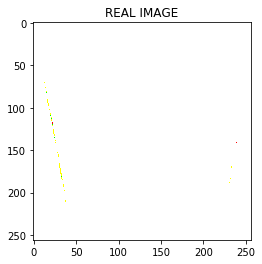

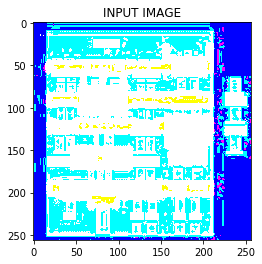

In [7]:
SAMPLE_INPUT = PATH_TO_DATA + "train/100.jpg"
input_, real = load_image(SAMPLE_INPUT)
plt.figure()
plt.imshow(real)
plt.title("REAL IMAGE")

plt.figure()
plt.imshow(input_)
plt.title("INPUT IMAGE")

In [8]:
#define a function to resize the image
def resize(input_image, real_image, img_height, img_width):
    inp = tf.image.resize(input_image, [img_height, img_width])
    real = tf.image.resize(real_image, [img_height, img_width])
    
    return inp, real

def crop(input_image, real_image, img_height, img_width):
    stack_img = tf.stack([input_image, real_image], axis = 0)
    random_crop = tf.image.random_crop(stack_img, size = [2, img_height, img_width, 3])
    
    return random_crop[0], random_crop[1]

def normalize(input_image, real_image):
    inp = (input_image / 127.5) - 1
    real = (real_image / 127.5) - 1
    
    return inp, real

In [9]:
def random_changes(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)
    input_image, real_image = crop(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)
    
    return input_image, real_image

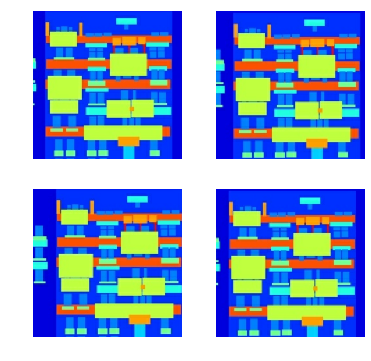

In [10]:
# As you can see in the images below
# that they are going through random jittering
# Random jittering as described in the paper is to
# 1. Resize an image to bigger height and width
# 2. Randomnly crop to the original size
# 3. Randomnly flip the image horizontally
plt.figure(figsize = (6, 6))
for i in range(4):
    rj_inp, rj_re = random_changes(input_, real)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()

In [11]:
#load the train and test images
def load_train_image(image_file):
    input_image, real_image = load_image(image_file) 
    input_image, real_image = random_changes(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

def load_test_image(image_file):
    input_image, real_image = load_image(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

In [12]:
#let's load the images from the local machine
PATH_TO_TRAIN = PATH_TO_DATA + "train/*.jpg" 
PATH_TO_TEST = PATH_TO_DATA + "test/*.jpg"
train_data = tf.data.Dataset.list_files(PATH_TO_TRAIN)
train_data = train_data.shuffle(BUFFER_SIZE)
train_data = train_data.map(load_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_data = train_data.batch(BATCH_SIZE)

In [14]:
test_data = tf.data.Dataset.list_files(PATH_TO_TEST)
# shuffling so that for every epoch a different image is generated
# to predict and display the progress of our model.
train_data = train_data.shuffle(BUFFER_SIZE)
test_data = test_data.map(load_test_image)
test_data = test_data.batch(1)

In [15]:
input_img, real_img = next(iter(train_data.take(1)))

W0519 15:23:14.989360  8596 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0519 15:23:15.001328  8596 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


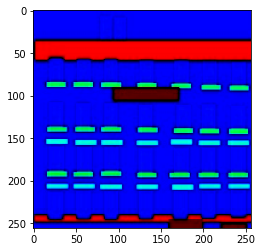

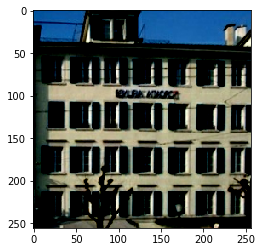

In [16]:
plt.figure()
plt.imshow(tf.reshape(input_img, (256, 256, 3)))

plt.figure()
plt.imshow(tf.reshape(real_img, (256, 256, 3)))
plt.show()

#### Build the Generator

1. The architecture of generator is a modified U-Net.
2. Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
3. Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
4. There are skip connections between the encoder and decoder (as in U-Net).

In [17]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Concatenate, concatenate
from tensorflow.keras.layers import ZeroPadding2D

from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

from tensorflow.keras.models import Sequential

In [18]:
def downsample(filters, filter_size):
    model = Sequential()
    model.add(Conv2D(filters, filter_size, padding = "same", strides = 2, kernel_initializer = "glorot_uniform",
                    use_bias = False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    return model

In [19]:
def upsample(filters, filter_size, apply_dropout = False):
    model = Sequential()
    model.add(Conv2DTranspose(filters, filter_size, padding = "same", strides = 2, kernel_initializer = "glorot_uniform",
                             use_bias = False))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(ReLU())
    
    return model

In [20]:
OUTPUT_CHANNELS = 3

def Generator():
    downsample_stack = [
        downsample(64, 4),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    
    upsample_stack = [
        upsample(512, 4, apply_dropout = True),
        upsample(512, 4, apply_dropout = True),
        upsample(512, 4, apply_dropout = True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    
    last = Conv2DTranspose(OUTPUT_CHANNELS, 4, padding = "same", strides = 2, kernel_initializer = "glorot_uniform")
    
    concat = Concatenate()
    
    inputs = Input(shape = [None, None, 3])
    x = inputs
    
    skips = []
    
    for down in downsample_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    for up, skip in zip(upsample_stack, skips):
        x = up(x)
        x = concat([x, skip])
        
    output = last(x)
    
    return Model(inputs = inputs, outputs = output)

In [21]:
generator = Generator() #instantiate the above function
gen_output = generator(input_[tf.newaxis,...]) #checking the function on a sample image

W0519 15:23:33.383668  8596 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


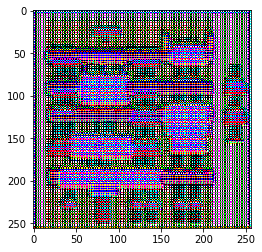

In [23]:
plt.imshow(gen_output[0]) #visualizing the the Generator output

#### Build the Discriminator

1. The Discriminator is a PatchGAN.
2. Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
3. The shape of the output after the last layer is (batch_size, 30, 30, 1)
4. Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
5. Discriminator receives 2 inputs.
        Input image and the target image, which it should classify as real.
        Input image and the generated image (output of generator), which it should classify as fake.
        We concatenate these 2 inputs together in the code (tf.concat([inp, tar], axis=-1))

In [24]:
def Discriminator():
    
    inp = Input(shape = [None, None, 3], name = "InputImage")
    tar = Input(shape = [None, None, 3], name = "TargetImage")
    
    x = concatenate([inp, tar]) # (bs, 256, 256, channels*2)
    
    down1 = downsample(64, 4)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    
    pad1 = ZeroPadding2D()(down3)# (bs, 34, 34, 256)
    
    conv = Conv2D(512, 4, padding = "same", strides = 1,kernel_initializer = "glorot_uniform", use_bias = False)(pad1)# (bs, 31, 31, 512)
    
    batch_norm = BatchNormalization()(conv)
    
    leaky_relu = LeakyReLU()(batch_norm)
    
    pad2 = ZeroPadding2D()(leaky_relu)# (bs, 33, 33, 512)
    
    last = Conv2D(1, 4, strides = 2, padding = "same")(pad2) # (bs, 30, 30, 1)
    
    return Model(inputs = [inp, tar], outputs = last)

In [25]:
discriminator = Discriminator()
dis_output = discriminator([input_[tf.newaxis,...], gen_output])

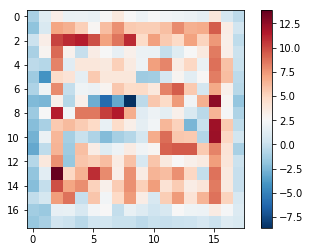

In [26]:
plt.imshow(dis_output[0,...,-1], cmap = "RdBu_r")
plt.colorbar()

### Define the loss functions and the optimizer

###### Discriminator loss
1. The discriminator loss function takes 2 inputs; real images, generated images
2. real_loss is a sigmoid cross entropy loss of the real images and an array of ones(since these are the real images)
3. generated_loss is a sigmoid cross entropy loss of the generated images and an array of zeros(since these are the fake images)
4. Then the total_loss is the sum of real_loss and the generated_loss

###### Generator loss
1. It is a sigmoid cross entropy loss of the generated images and an array of ones.
2. The paper also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
3. This allows the generated image to become structurally similar to the target image.
4. The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the paper.

In [27]:
LAMBDA = 100

In [28]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [29]:
def discriminator_loss(disc_real_output, disc_generated_output):
    
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

In [30]:
def generator_loss(disc_generated_output, gen_output, target):
    
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [33]:
checkpoint_dir = './pix2pix_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

#### Training

1. We start by iterating over the dataset
2. The generator gets the input image and we get a generated output.
3. The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
4. Next, we calculate the generator and the discriminator loss.
5. Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
6. This entire procedure is shown in the images below.

In [46]:
EPOCHS = 50

In [47]:
def generate_images(model, test_input, tar):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
    prediction = model(test_input, training = True)
    plt.figure(figsize = (15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [48]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training = True)

        disc_real_output = discriminator([input_image, target], training = True)
        disc_generated_output = discriminator([input_image, gen_output], training = True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [49]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

    for input_image, target in dataset:
        train_step(input_image, target)

    #clear_output(wait = True)
    for inp, tar in test_data.take(1):
        generate_images(generator, inp, tar)

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

W0519 16:49:11.078352  8596 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


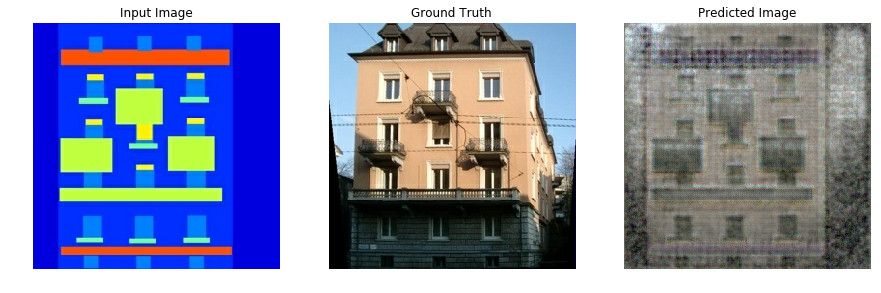

Time taken for epoch 50 is 1022.7403826713562 sec



In [50]:
train(train_data, EPOCHS)

W0519 17:23:47.357768  8596 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


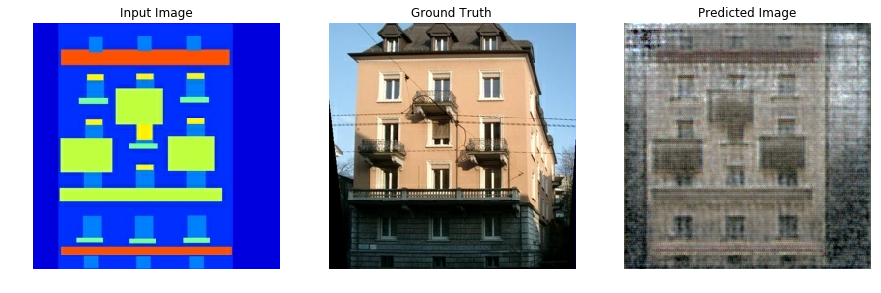

Time taken for epoch 100 is 1054.856204032898 sec



In [51]:
train(train_data, epochs = 100)

W0519 17:48:13.629518  8596 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


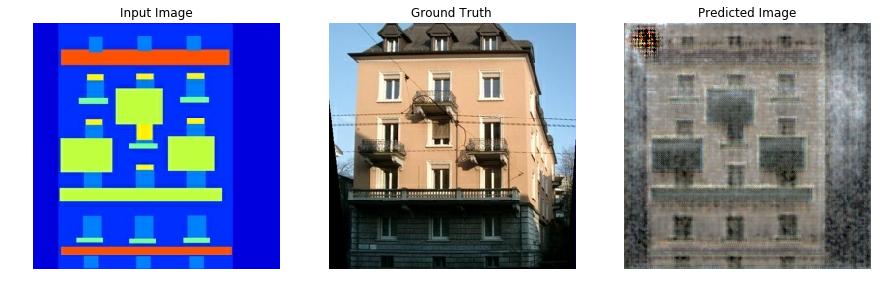

Time taken for epoch 200 is 976.9194712638855 sec



In [52]:
train(train_data, epochs = 200)

W0519 18:13:05.862440  8596 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


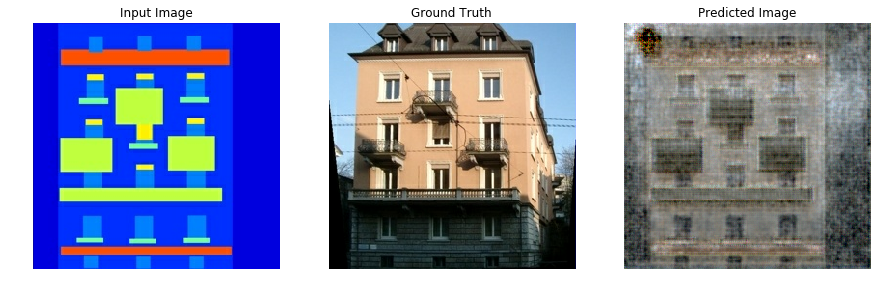

Time taken for epoch 400 is 420.15260887145996 sec



In [53]:
train(train_data, epochs = 400)